##### Using CAPM model to estimate returns for FANG (facebook, Amazon, Netflix, and Google) companies

In [3]:
!pip install -q yfinance

In [0]:
from pandas import DataFrame
from datetime import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

Generally, a portfolio has two types of risks.
1. Idiosyncratic Risk: These type of risks are firm specific risks and can be diversified by diversifying the investments in the portfolio accordingly.
2. Systematic Risk: These risks are not firm specific and have effects on the entire market. A change in a macroeconomic factor, such as an interest rate is an an example of systematic risk.

The Capital Asset Pricing Model (CAPM) is one of the fundamental models in finance that uses the asset prices to estimate the returns of investing in that asset after taking into account the market risk. 

Ideally speaking, if an investor aims to invest in a certain asset, the investor would want the investment to be risk free. Since there are no free lunches in finance, the investor should be incentivized to make the investment. The investor is incentivized by a risk-premium. i.e the difference between the market risk rate and risk free rate.


Mathematically, the CAPM model is written as follow:

$$ E[R_i]\space=\space R_f \space+\space \beta(E[R_m]\space-\space[R_f]) $$

Where $R_i$ is the return on asset, $R_f$ is the risk free return, and $R_m$ is the market risk.

In order to quantify market risk and risk free rate, we use the following proxies:

$$R_f\space =\space 3\space Month\space US\space Treasury\space Bill$$
$$R_m\space =\space SNP500$$

Generally, CAPM model determines the minimum risk that should an asset should offer in order to incentivize or entice someone to invest in that asset. Since the systematic risk cannot be diversified or controlled, the model dictates that the return on the asset should be risk-free rate plus something in access of the market risk to compensate for the systematic risk

In [287]:
#let's get the daily historical stock prices for FANG companies , S&P500, and the 3month Treasury bill returns
start_date = "2019-01-01"
end_date = "2019-12-31"

tickers = ["FB","AMZN","NFLX","GOOGL","SNP","^IRX"]
masterdata = DataFrame(yf.download(tickers, start = start_date , end = end_date , interval='1d'))

#masterdata.reset_index(inplace=True,drop=False,)
closing_prices = masterdata[["Adj Close"]]

#let's drop the additional column level in the dataframe
closing_prices.columns = closing_prices.columns.droplevel()

[*********************100%***********************]  6 of 6 completed


Following equation, using the regression technique, will be used to estimate the value for $\beta$

$$ R_i - R_f = \alpha + \beta(R_m - R_f) + \epsilon $$

where

$$ R_i\space=\space rate\space of\space return\space on\space portfolio$$
$$ R_f\space=\space risk\space free\space rate \space of \space return$$
$$ R_m\space=\space return \space on \space market \space potfolio $$
$$ \alpha,\space \beta,\space and \space \epsilon \space are \space parameters \space and \space error,\space respectively $$

In [288]:
# We need to do a little bit of data wrangling to get the data in the desired form.
# The rates for Tbills are annualized and in percentages, therefore; we need to first convert them to daily rates.

closing_prices["daily_rates"] = (closing_prices["^IRX"]/100)/252

# Let's create a separate dataframe that contains the percentage change of all the stock prices, to give us returns.
# Also let's get the return or percentage change on the SNP500 and drop the NA values from the data frame

returns = DataFrame({"AMZN":closing_prices["AMZN"].pct_change(),"FB":closing_prices["FB"].pct_change(),"GOOGL":closing_prices["GOOGL"].pct_change(),
                    "NFLX":closing_prices["NFLX"].pct_change(),"SNP":closing_prices["SNP"].pct_change(),"RF":closing_prices["daily_rates"]})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [289]:
returns = returns.dropna()
returns

,AMZN,FB,GOOGL,NFLX,SNP,RF
Date,,,,,,
2019-01-03,-0.025242,-0.029039,-0.027696,0.013226,-0.002654,0.000093
2019-01-04,0.050064,0.047138,0.051294,0.097234,0.018630,0.000094
2019-01-07,0.034353,0.000725,-0.001994,0.059717,0.007563,0.000093
2019-01-08,0.016612,0.032452,0.008783,0.015634,0.021837,0.000095
2019-01-09,0.001714,0.011927,-0.003427,-0.000968,0.034593,0.000095
...,...,...,...,...,...,...
2019-12-20,-0.003225,0.001165,-0.003848,0.014087,0.008376,0.000061
2019-12-23,0.003638,-0.000582,-0.000437,-0.011279,0.006781,0.000060
2019-12-26,0.044467,0.013017,0.013418,-0.001711,0.005057,0.000061


In [0]:
#The function below takes the name of the asset as an input and plot the graph of returns for that asset along with SNP500, and 3 Month TBill

def plot_graphs(asset_name):
  fig, ax = plt.subplots(figsize=(20, 10))
  ax.plot(returns[asset_name], label = asset_name)
  ax.plot(returns["SNP"], label = "SNP500")
  ax.plot(returns["RF"], label = "TBill")
  ax.legend()
  plt.xlabel("Time")
  plt.ylabel("Daily Returns")
  return plt.show()

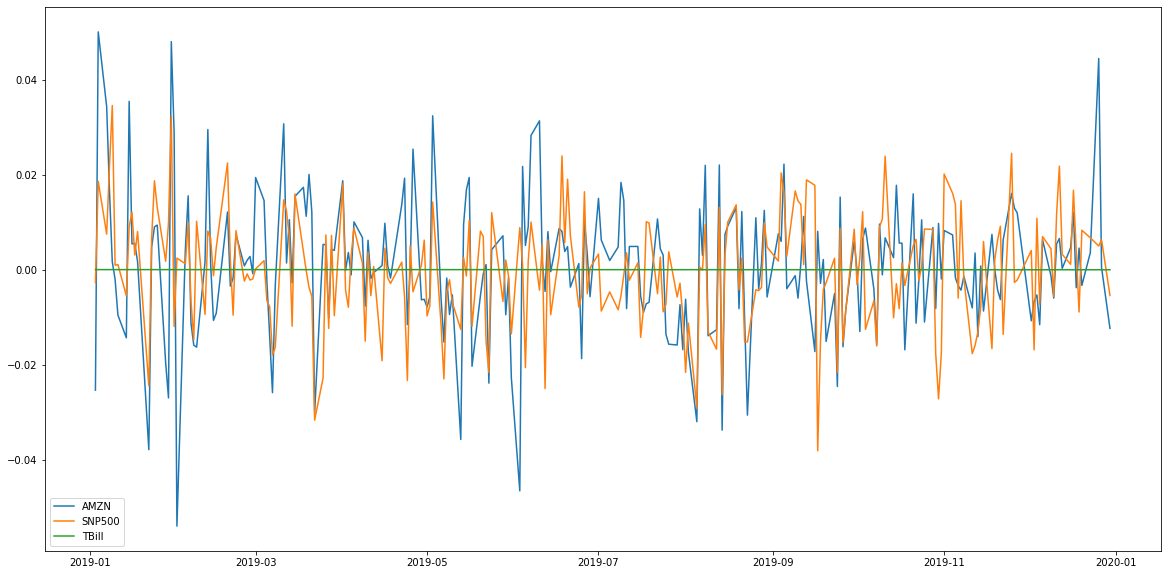

In [291]:
plot_graphs("AMZN")

In [296]:
# Let's find the market beta for AMZN, using the linear regression model
rf = returns["RF"]
rm = returns["SNP"]

rm_rf = np.array(rm - rf)

def calculating_R(dataframe, asset_name):
  ri_rf = dataframe[asset_name] - rf
  return ri_rf

Y = calculating_R(returns,"AMZN")
X = np.array(sm.add_constant(rm_rf))
lin_reg = sm.regression.linear_model.OLS(Y, X)
results = lin_reg.fit()
results.summary(xname=["alpha","beta"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     52.57
Date:                Sat, 04 Apr 2020   Prob (F-statistic):           5.41e-12
Time:                        19:20:22   Log-Likelihood:                 720.07
No. Observations:                 247   AIC:                            -1436.
Df Residuals:                     245   BIC:                            -1429.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha          0.0009      0.001      1.125      0.262      -0.001       0.003
beta           0.5142      0.071      7.251      0.000       0.374       0.654
==============================================================================
Omnibus:                       17.433   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.591
Skew:                          -0.164   Prob(JB):                     1.70e-11
Kurtosis:                       5.171   Cond. No.                         84.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looking at the regression results, we see that the value for beta is 0.51. The beta value tells us that our stock is relatively less risk as compared to the movements in the market. A 1% change in excess market returns will should only expect a 0.51% change in the returns for our stock.

The p-value for beta is 0.000, which means that the results are statistically significant.

The coefficient value for alpha is 0.0009. This means if we eliminate the market risk, we can expect a return of 0.0009% on the stock of interest. However, the p-value of 0.262 suggests that the results are statistically insignificant. Therefore, we cannot reject the null hypothesis that the alpha estimate is different than 0.

From what it looks like Amazon stock is less volatile as compared to the S&P500.

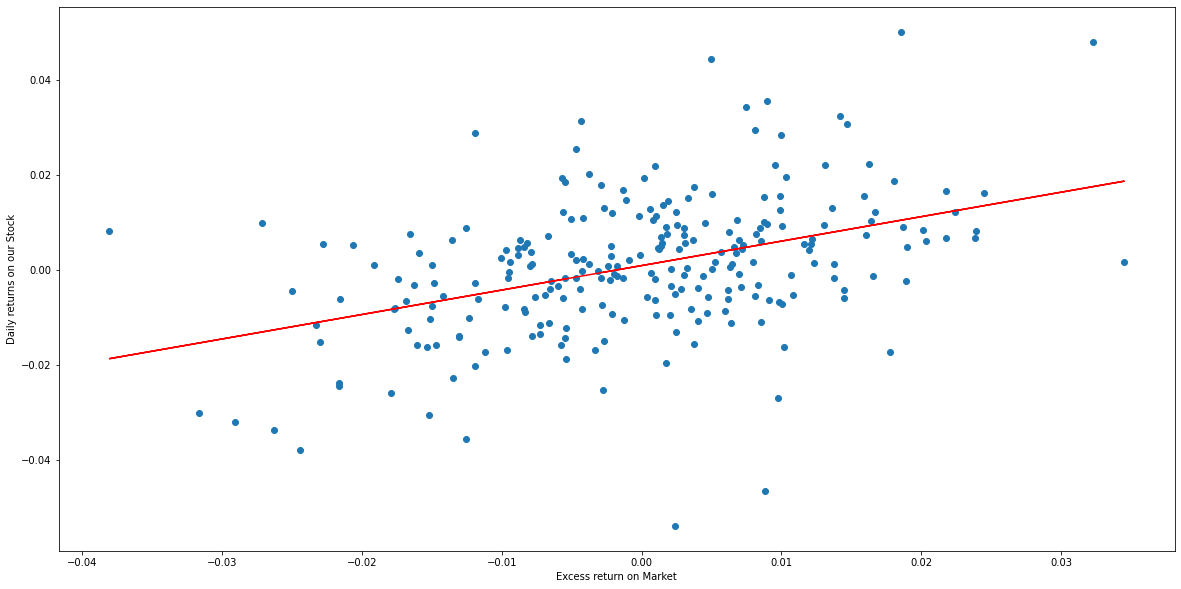

In [301]:
#Let's see the regression plot between the (Rm-Rf) and the return on the stock of our interest
y = results.params[0] + results.params[1] * (rm_rf)

fig, ax = plt.subplots(figsize = (20,10))
ax.scatter(rm_rf, returns["AMZN"])
ax.plot(rm_rf, y, color="r")
plt.xlabel("Excess return on Market")
plt.ylabel("Daily returns on our Stock")
plt.show()

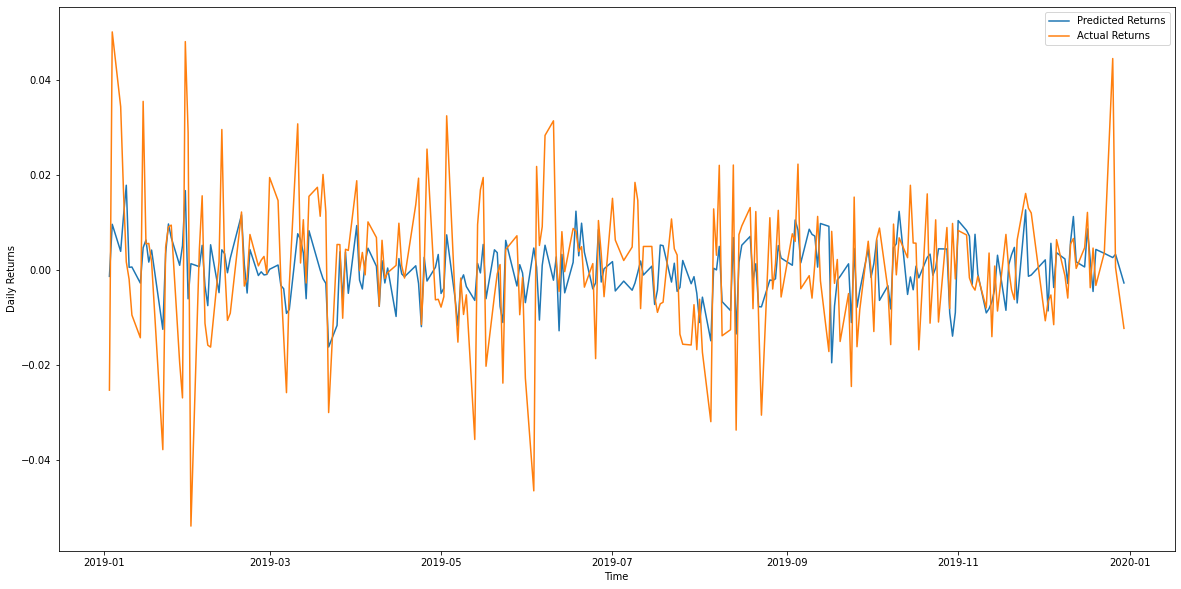

In [302]:
# Let's calculate the predicted returns and compare them with the actual returns on Amazon
amzn_beta = results.params[1]
predicted_returns = rf + amzn_beta*(rm_rf)

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(predicted_returns, label="Predicted Returns")
ax.plot(returns["AMZN"], label="Actual Returns")
ax.legend()
plt.xlabel("Time")
plt.ylabel("Daily Returns")
plt.show()